### Importing Libraries for Computer Vision and GradCAM Evaluation

In [1]:
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import kagglehub
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import plotly.express as px
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

from keras.callbacks import EarlyStopping as ES, ModelCheckpoint as MC

from tensorflow.keras.applications import ResNet50V2, ResNet50, InceptionV3, Xception

### Loading Dataset


*LINK to Kaggle dataset below*

[![Kaggle Dataset](https://img.shields.io/badge/Kaggle-Microorganism_Image_Classification-blue.svg?logo=kaggle&style=for-the-badge)](https://www.kaggle.com/datasets/mdwaquarazam/microorganism-image-classification/data)

In [2]:
path = kagglehub.dataset_download("mdwaquarazam/microorganism-image-classification")
print(f"Path to dataset files: {path}")

subfolder_name = os.listdir(path)[0] 
data_dir = os.path.join(path, subfolder_name)

classes_names = sorted(os.listdir(data_dir))
n_classes = len(classes_names)

class_distribution = {name: len(os.listdir(os.path.join(data_dir, name))) for name in classes_names}

print(f"Number of classes: {n_classes} \nClass Names: {classes_names}")

Path to dataset files: C:\Users\chris\.cache\kagglehub\datasets\mdwaquarazam\microorganism-image-classification\versions\6
Number of classes: 8 
Class Names: ['Amoeba', 'Euglena', 'Hydra', 'Paramecium', 'Rod_bacteria', 'Spherical_bacteria', 'Spiral_bacteria', 'Yeast']


### Exploratory Data Analysis

In [3]:
total_images = sum(class_distribution.values())


text_labels = [f'{(value / total_images) * 100:.2f}%' for value in class_distribution.values()]

fig = px.bar(
    x=classes_names, 
    # Make Y a %
    y=[(value / total_images) * 100 for value in class_distribution.values()], 
    text=text_labels, 
    title="Microorganism Class Distribution"
)

fig.update_traces(textposition='outside')

fig.update_layout({'title': {'x':0.5}})

fig.show()

### EDA Interpretation
- It appears the number of obervations for each lass is unevenly distirbuted in the dataset. 
- some classes appear to have more data(Euglena & Paramecium) while some have less(Hydra and Amoeba) 

### Data Pre-Processing

In [ ]:
gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    validation_split=0.1
)

### Defining Training & Validation Sets

In [ ]:
train_df = gen.flow_from_directory(
    data_dir,
    batch_size=128,
    shuffle=True,
    class_mode='sparse',  
    target_size=(256,256),
    subset='training'
)

val_df = gen.flow_from_directory(
    data_dir,
    batch_size=64,
    shuffle=True,
    class_mode='sparse',  
    target_size=(256,256),
    subset='validation'
)

Found 714 images belonging to 8 classes.
Found 75 images belonging to 8 classes.


### Function to Visulaize Images

In [ ]:
def visualize_images(data, GRID=[2,6], model=None, size=(25,10)):

    n_row, n_col = GRID
    n_images = n_row * n_col
    plt.figure(figsize = size)

    images,labels = next(iter(data))

    for i in range(1, n_images + 1):

        id = np.random.randint(len(images))

        image, label = images[id], classes_names[int(labels[id])]

        plt.subplot(n_row,n_col, i)
        plt.imshow(image)
        plt.axis('off')


        if model is not None:
            pred = classes_names[np.argmax(model.predict(image[np.newaxis,...]))]
            title = f"Class: {label}\nPred: {pred}"

        else:
            title = f"Class: {label}"

        plt.title(title)
    plt.show()

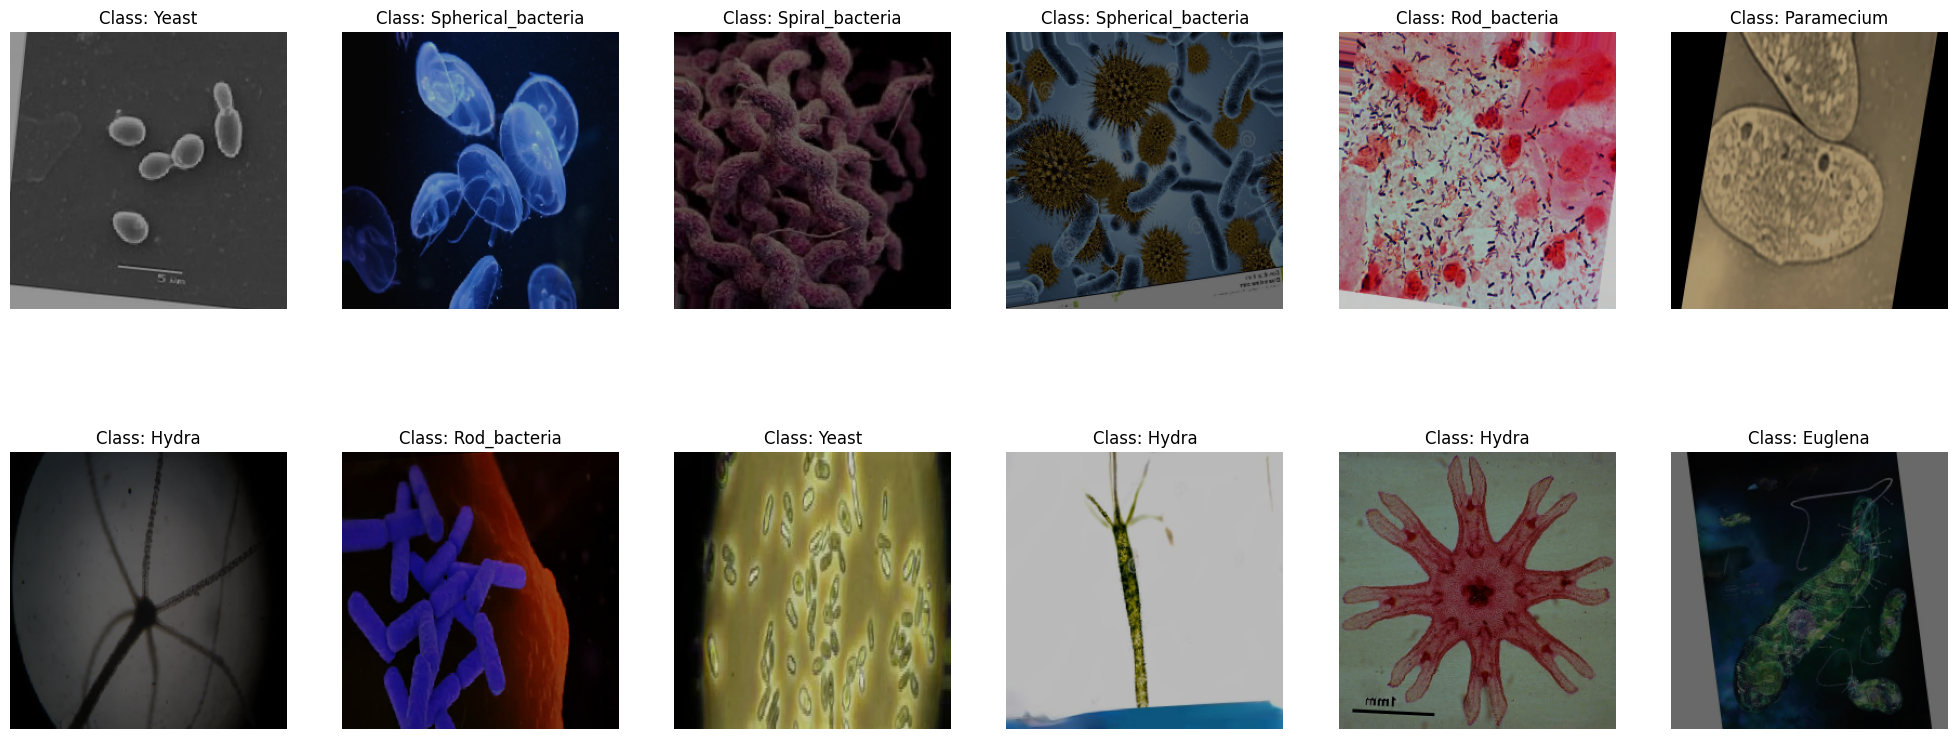

In [ ]:
visualize_images(data=train_df, model=None)

# Implementing Inception-v3-Model (NO GradCAM Yet)

In [ ]:
name = "inception-v3"

base = InceptionV3(input_shape=(256,256,3), include_top=False, weights='imagenet')
base.trainable = False

inputs = tf.keras.Input(shape=(256, 256, 3))
x = base(inputs, training=False)
x = GAP()(x)
x = Dense(256, kernel_initializer='he_normal', activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(n_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

callbacks = [ES(patience=3, restore_best_weights=True), MC(name + '.h5', save_best_only=True)]

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss ='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(train_df, validation_data=val_df, epochs=50, callbacks=callbacks)

c:\Users\chris\miniforge3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2220 - loss: 2.7089

6/6 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - accuracy: 0.2255 - loss: 2.5645 - val_accuracy: 0.2667 - val_loss: 1.8579
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3678 - loss: 1.7125

6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - accuracy: 0.3964 - loss: 1.6419 - val_accuracy: 0.5067 - val_loss: 1.4158
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5395 - loss: 1.3081

6/6 ━━━━━━━━━━━━━━━━━━━━ 44s 7s/step - accuracy: 0.5784 - loss: 1.2823 - val_accuracy: 0.6533 - val_loss: 1.1850
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6718 - loss: 1.1114

6/6 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - accuracy: 0.6401 - loss: 1.1343 - val_accuracy: 0.6400 - val_loss: 1.0916
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6709 - loss: 1.0043

6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.6709 - loss: 0.9844 - val_accuracy: 0.6800 - val_loss: 1.0867
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7097 - loss: 0.8867

6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.6933 - loss: 0.9057 - val_accuracy: 0.6400 - val_loss: 1.0419
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7600 - loss: 0.7841

6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - accuracy: 0.7479 - loss: 0.7866 - val_accuracy: 0.7200 - val_loss: 0.9538
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.7801 - loss: 0.6925 - val_accuracy: 0.6800 - val_loss: 0.9683
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.7885 - loss: 0.6587 - val_accuracy: 0.6667 - val_loss: 1.0345
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8001 - loss: 0.6019

6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - accuracy: 0.7983 - loss: 0.6103 - val_accuracy: 0.7333 - val_loss: 0.9255
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - accuracy: 0.8221 - loss: 0.5487 - val_accuracy: 0.7200 - val_loss: 0.9666
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.8515 - loss: 0.4856 - val_accuracy: 0.6933 - val_loss: 0.9660
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8403 - loss: 0.4801

6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.8515 - loss: 0.4690 - val_accuracy: 0.7333 - val_loss: 0.9092
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - accuracy: 0.8768 - loss: 0.4351 - val_accuracy: 0.7067 - val_loss: 0.9139
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.8950 - loss: 0.3868 - val_accuracy: 0.7333 - val_loss: 0.9821
Epoch 16/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.8978 - loss: 0.3569 - val_accuracy: 0.7200 - val_loss: 0.9685


### Initial Prediciton vs Actual Class Comparison

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


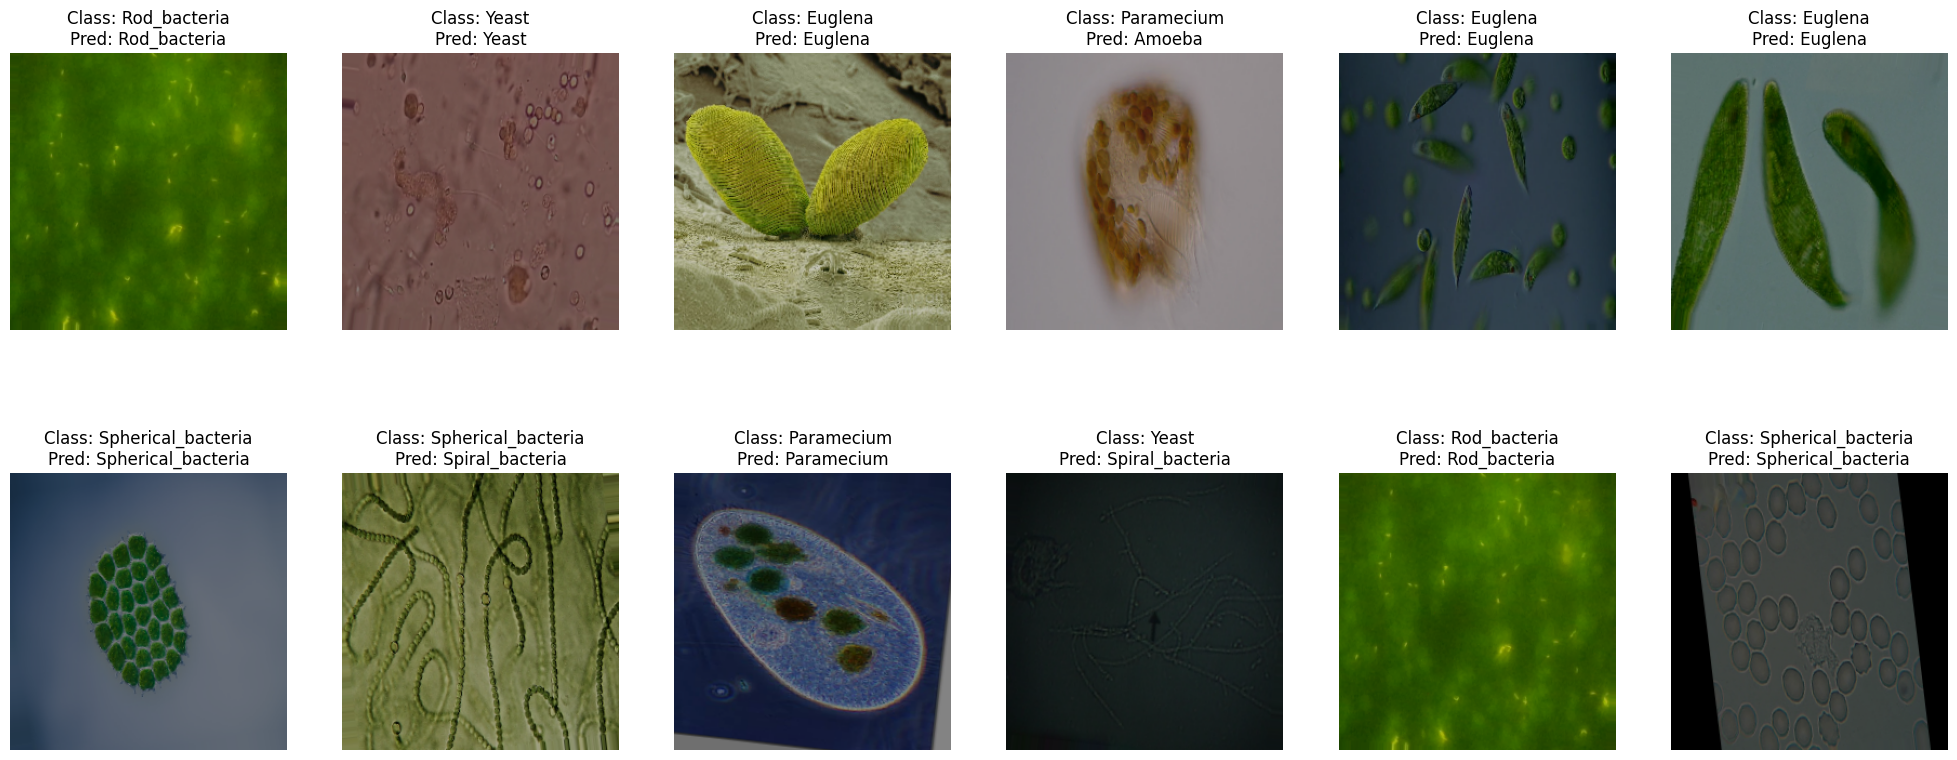

In [ ]:
visualize_images(data = val_df, model=model)

In [ ]:
def generate_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # This is the final, most robust implementation that bypasses the Keras bug.
    
    # Create a simple feature extractor model that outputs the last conv layer's activations
    last_conv_layer = model.get_layer('inception_v3').get_layer(last_conv_layer_name)
    feature_extractor = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Use GradientTape to compute the gradient of the predicted class
    with tf.GradientTape() as tape:
        # Get the feature map for the input image
        features = feature_extractor(img_array)
        # We must "watch" this tensor for the gradient calculation to work
        tape.watch(features)

        # Manually apply the classifier layers to the features to get the final prediction
        # The classifier head starts at model.layers[2] (the GlobalAveragePooling2D layer)
        x = features
        for i in range(2, len(model.layers)):
            x = model.layers[i](x)
        preds = x # This is now the final prediction tensor

        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron with respect to the output feature map
    grads = tape.gradient(class_channel, features)

    # Pool the gradients and weight the feature map channels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    features = features[0]
    heatmap = features @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap for visualization
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

### Implementing GradCAM into Model

In [ ]:
# Find the base model and the last conv layer by name
base_model = model.get_layer('inception_v3')
last_conv_layer_name = base_model.layers[-1].name
print(f"Using target layer: {last_conv_layer_name}")

# Get one image per class for visualization
images_by_class = {}
while len(images_by_class) < n_classes:
    images, labels = next(val_df)
    for img, label in zip(images, labels):
        label_index = int(label)
        if label_index not in images_by_class:
            images_by_class[label_index] = img
        if len(images_by_class) == n_classes:
            break
            
sorted_items = sorted(images_by_class.items())
sample_images = np.array([item[1] for item in sorted_items])
sample_labels = np.array([item[0] for item in sorted_items])
preds = model.predict(sample_images)
pred_indices = np.argmax(preds, axis=1)

# Visualization Code
plt.figure(figsize=(24, 8))
for i in range(8):
    img = sample_images[i]
    img_array = np.expand_dims(img, axis=0)

    # Call the function
    heatmap = generate_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=pred_indices[i])

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + np.uint8(255 * img)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    actual_class = classes_names[int(sample_labels[i])]
    predicted_class = classes_names[pred_indices[i]]

    plt.subplot(2, 8, i + 1)
    plt.imshow(img)
    plt.title(f"Original\nActual: {actual_class}")
    plt.axis('off')

    plt.subplot(2, 8, i + 8 + 1)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM\nPredicted: {predicted_class}")
    plt.axis('off')

plt.suptitle("Grad-CAM Visualization (Pure TensorFlow)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Using target layer: mixed10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


KeyError: "Exception encountered when calling Functional.call().\n\n\x1b[1m2107537701872\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=array([[[[0.6039216 , 0.61960787, 0.6509804 ],\n         [0.6039216 , 0.61960787, 0.6509804 ],\n         [0.6039216 , 0.61960787, 0.6509804 ],\n         ...,\n         [0.57254905, 0.56078434, 0.5764706 ],\n         [0.57254905, 0.5568628 , 0.5764706 ],\n         [0.5647059 , 0.54901963, 0.5764706 ]],\n\n        [[0.6039216 , 0.61960787, 0.6509804 ],\n         [0.6039216 , 0.61960787, 0.6509804 ],\n         [0.6039216 , 0.61960787, 0.6509804 ],\n         ...,\n         [0.57254905, 0.56078434, 0.5764706 ],\n         [0.57254905, 0.5568628 , 0.5764706 ],\n         [0.5647059 , 0.54509807, 0.57254905]],\n\n        [[0.60784316, 0.61960787, 0.6509804 ],\n         [0.60784316, 0.61960787, 0.6509804 ],\n         [0.60784316, 0.61960787, 0.6509804 ],\n         ...,\n         [0.57254905, 0.56078434, 0.5764706 ],\n         [0.57254905, 0.5529412 , 0.5764706 ],\n         [0.5647059 , 0.54509807, 0.57254905]],\n\n        ...,\n\n        [[0.60784316, 0.60784316, 0.6313726 ],\n         [0.60784316, 0.60784316, 0.627451  ],\n         [0.60784316, 0.60784316, 0.627451  ],\n         ...,\n         [0.5686275 , 0.53333336, 0.50980395],\n         [0.5686275 , 0.53333336, 0.50980395],\n         [0.5686275 , 0.53333336, 0.50980395]],\n\n        [[0.60784316, 0.60784316, 0.6313726 ],\n         [0.60784316, 0.60784316, 0.627451  ],\n         [0.60784316, 0.60784316, 0.627451  ],\n         ...,\n         [0.5686275 , 0.53333336, 0.50980395],\n         [0.5686275 , 0.53333336, 0.50980395],\n         [0.5686275 , 0.53333336, 0.50980395]],\n\n        [[0.60784316, 0.60784316, 0.627451  ],\n         [0.60784316, 0.60784316, 0.627451  ],\n         [0.60784316, 0.60784316, 0.627451  ],\n         ...,\n         [0.5686275 , 0.53333336, 0.50980395],\n         [0.5686275 , 0.53333336, 0.50980395],\n         [0.5686275 , 0.53333336, 0.50980395]]]],\n      shape=(1, 256, 256, 3), dtype=float32)\n  • training=None\n  • mask=None\n  • kwargs=<class 'inspect._empty'>"

<Figure size 2400x800 with 0 Axes>

: 

### Implementing GradCAM - with Variant 1 into Model 

### Implementing GradCAM with Variant 2 into Model 